### About the model
The model is a Multi-Layer Perceptron with 3 hidden layers. It gets 5 days' daily average temperature values as inputs and outputs a prediction for the next day. This notebook contains every information about the model, code for loading the data and train the model, but there are also saved models in the project directory.

There are two flags in this notebook to configure its behavior:
- *normalization_flag* : If True, the loaded data will be normalized before training and scaled back after prediction. If False, all data will remain in degrees Celsius.
- *you_are_sure_about_this* : If True, a new model will be trained (it may take 1-3 mins). If False, the notebook loads in a trained and saved set of weights for the model.

Hyperparameters of the model:
- *input_seq_length* : The length of the input sequence in days. The best performing model gets 5 days' data to predict the next day.
- *num_of_neurons* : A list containing the widths of the hidden layers and the output layer. The number of layers can be altered if one adds or removes a value from this list because the model is built in a for-loop running through it. The best performing model has 3 hidden layers with 10-20-8 neurons, respectively, and 1 output neuron.
- *learning_rate* : Learning rate parameter for the Adam optimizer. Its set to 1e-4.
- *batch_size* : Set to 64.
- *num_of_epochs* : Set to 9001 because the training uses early stopping and model checkpoint.

How to use a pretrained model? 
- The configuration of the model is not saved so one should construct a model same as here. The weights can be loaded after. There are weights saved for both normalized and not normalized data.
- The model operates on daily average temperatures in degrees Celsius. 5 days' data should be presented to the models input layer to make a prediction for the following day. Predictions for days further than that can be predicted if one feeds the model's predicted temperature value back to it's input.

In [18]:
import csv
from numpy import array
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint

### About the data

The dataset is a preprocessed version of the weather data available at http://idojarasbudapest.hu/archivalt-idojaras. Preprocessed means it has been downloaded and cleaned into a simple set of CSV files named in 'YY_MM_prep.csv' containing three comma-separated values in every line: day of the month, max. temperature, min. temperature. The notebook loads the contents of these files into training, validation and test datasets and performs some additional data processing.

### Loading the data
The training data will be the first part of the data from 2011 to 2017. Every line from every CSV file from this period will be read in, a daily average temperature will be calculated for every line and then added to the *training_data* list. (This list will later be processed into input-output pairs under the *Preprocessing* section.)

In [2]:
# Loading the training data

training_data = list()

for year in range(11, 18):
    for month in range(1, 13):
        
        if year is 11 and month < 10:
            continue
        
        month_str = ''
        if month < 10:
            month_str = '0' + str(month)
        else:
            month_str = str(month)
        
        file_name = str(year) + '_' + month_str + '_prep'
        with open('dataset/' + file_name + '.csv', 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            # print('Loading', '20'+str(year), month_str)
            for row in reader:
                average_temperature_of_the_day = (float(row[1]) + float(row[2])) / 2.0
                training_data.append(average_temperature_of_the_day)

In [3]:
# Loading the validation data

validation_data = list()

year = 18
for month in range(1, 13):

    month_str = ''
    if month < 10:
        month_str = '0' + str(month)
    else:
        month_str = str(month)

    file_name = str(year) + '_' + month_str + '_prep'
    with open('dataset/' + file_name + '.csv', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        # print('Loading', '20'+str(year), month_str)
        for row in reader:
            average_temperature_of_the_day = (float(row[1]) + float(row[2])) / 2.0
            validation_data.append(average_temperature_of_the_day)

In [4]:
# Loading the test data

test_data = list()

year = 19
for month in range(1, 11):

    month_str = ''
    if month < 10:
        month_str = '0' + str(month)
    else:
        month_str = str(month)

    file_name = str(year) + '_' + month_str + '_prep'
    with open('dataset/' + file_name + '.csv', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        # print('Loading', '20'+str(year), month_str)
        for row in reader:
            average_temperature_of_the_day = (float(row[1]) + float(row[2])) / 2.0
            test_data.append(average_temperature_of_the_day)

### Preprocessing
After loading the average temperature values into a long list, this list needs to be normalized and split into smaller sequences (input) and predictions (output). Since the length of the input sequence is a hyperparameter of the model this needs to be declared ahead of the other hyperparameters.

In [5]:
# Data normalization

normalization_flag = False

if normalization_flag:
    training_data   = array(training_data)
    validation_data = array(validation_data)
    test_data       = array(test_data)

    mean, std = training_data.mean(), training_data.std()

    training_data   = (training_data   - mean) / std
    validation_data = (validation_data - mean) / std
    test_data       = (test_data       - mean) / std

In [6]:
# Parameters of the model (part 1)
input_seq_length = 5

The slicing is carried out with a custom function that returns the list of the input vectors and the list of the predictions. This functions is called to the training, validation and test datasets separately, hence no overlap will be present between the training and other datasets.

In [7]:
# Function to split the sequence into input samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_idx = i + n_steps
        # Check if end_idx is beyond the dataset
        if end_idx > len(sequence)-1:
            break
        # Generating the sequence-prediction pairs
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

training_inputs,   training_predictions   = split_sequence(training_data, input_seq_length)
validation_inputs, validation_predictions = split_sequence(validation_data, input_seq_length)
test_inputs,       test_predictions       = split_sequence(test_data, input_seq_length)

print('Training inputs: ', training_inputs.shape, ' training predictions: ', training_predictions.shape)
print('Validation inputs: ', validation_inputs.shape, ' validation predictions: ', validation_predictions.shape)
print('Test inputs: ', test_inputs.shape, ' test predictions: ', test_predictions.shape)

Training inputs:  (2265, 5)  training predictions:  (2265,)
Validation inputs:  (360, 5)  validation predictions:  (360,)
Test inputs:  (294, 5)  test predictions:  (294,)


### Building the model
The following sections specify the model's architecture and hyperparameters and then compile the model. The first list called *num_of_neurons* is the most important becouse it holds how many layers will the model have and also how many neurons will be in each layer.

In [8]:
# Parameters of the model (part 2)
num_of_neurons   = list((10, 20, 8, 1))

learning_rate = 0.0001
size_of_batch = 64
num_of_epochs = 9001  # Its over nine thousand!

In [9]:
# Building the model
model_one = Sequential()
for i in range(len(num_of_neurons)):
    # Input layer
    if i is 0:
        model_one.add(Dense(num_of_neurons[i], activation='relu', input_dim=input_seq_length))
    # Output layer
    elif i is len(num_of_neurons)-1:
        model_one.add(Dense(num_of_neurons[i], activation='linear'))
    # Hidden layers
    else:
        model_one.add(Dense(num_of_neurons[i], activation='relu'))

opt = Adam(learning_rate)
model_one.compile(opt, loss=mean_squared_error)

model_one.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________


### Training the model
Training of the model is carried out here.

In [10]:
# Do you want to train the model again? Are you sure about that?
you_are_sure_about_this = False

if you_are_sure_about_this:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    
    history = model_one.fit(training_inputs, training_predictions,
                            validation_data=(validation_inputs, validation_predictions),
                            batch_size=size_of_batch,
                            epochs=num_of_epochs,
                            shuffle=True,
                            callbacks=[es, mc])
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    # Loading back the best model
    model_one.load_weights('best_model.h5')
    
else:
    if normalization_flag:
        model_one.load_weights('best_model_normalized.h5')
    else:
        model_one.load_weights('best_model_not_normalized.h5')

In [11]:
# Evaluation
val_loss = model_one.evaluate(validation_inputs, validation_predictions)
print('Validation loss is: ', val_loss)
loss = model_one.evaluate(test_inputs, test_predictions)
print('Test loss is: ', loss)


360/360 [==============================] - 0s 237us/step
Validation loss is:  4.011397337913513
294/294 [==============================] - 0s 66us/step
Test loss is:  5.002149507302005


In [12]:
# Error in degrees Celsius

if normalization_flag:
    error = np.sqrt(loss) * std
else:
    error = np.sqrt(loss)
print("Error in Celsius: ", error)

Error in Celsius:  2.236548570297995


**Note:** Its interesting to see that the models performance is approx. the same with and without normalization. You can try both configurations using the *normalization_flag* variable, see above.

### Examining long time prediction capabilities
The model is trained to predict only the next day's average temperature. This means that if one wants to "see further" should feed the model's predicted temperature into its input as a new measurement. The following two blocks of code demonstrates the capabilities of the model for longer predictions.

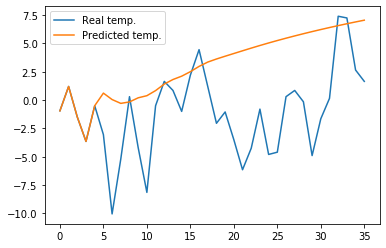

In [13]:
# Demonstration No.1

# Starting from the first 5 days of January 2019
predicted_month = list()
for i in range(5):
    predicted_month.append(test_data[i])

model_input = list()
model_input.append(test_data[:5])

# Iteratively predicting one month ahead
for i in range(31):
    prediction = model_one.predict(array(model_input))
    predicted_month.append(prediction[0][0])
    model_input = list()
    model_input.append(predicted_month[i+1:i+6])

# Real temperature values
real_measurements = list()
for i in range(36):
    real_measurements.append(test_data[i])

# Plotting both time-series
plt.plot(real_measurements, label='Real temp.')
plt.plot(predicted_month, label='Predicted temp.')
plt.legend()
plt.show()


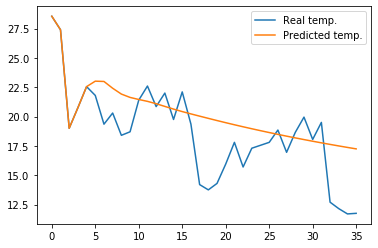

In [14]:
# Demonstration No.2

# Starting from the first 5 days of September 2019
predicted_month = list()
for i in range(5):
    predicted_month.append(test_data[243+i])

model_input = list()
model_input.append(test_data[243:248])

# Iteratively predicting one month ahead
for i in range(31):
    prediction = model_one.predict(array(model_input))
    predicted_month.append(prediction[0][0])
    model_input = list()
    model_input.append(predicted_month[i+1:i+6])

# Real temperature values
real_measurements = list()
for i in range(36):
    real_measurements.append(test_data[243+i])

# Plotting both time-series
plt.plot(real_measurements, label='Real temp.')
plt.plot(predicted_month, label='Predicted temp.')
plt.legend()
plt.show()


As one can see, the model does not follow the variation of the real temperature but somehow it correctly follows the trend of it.

### Making the requested predictions
The following block of code determines the temperatures values for the requested dates (30th Oct, 5th Nov, 26th Nov).

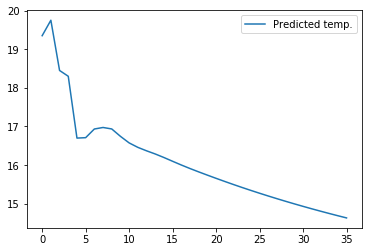

In [15]:
# Feeding in the last 5 days of the dataset (from 21th to 26th Oct)
predicted_month = list()
for i in range(5):
    predicted_month.append(test_data[-5+i])

model_input = list()
model_input.append(test_data[-5:])

# Iteratively predicting one month ahead
for i in range(31):
    prediction = model_one.predict(array(model_input))
    predicted_month.append(prediction[0][0])
    model_input = list()
    model_input.append(predicted_month[i+1:i+6])

# Plotting the time-series
plt.plot(predicted_month, label='Predicted temp.')
plt.legend()
plt.show()

In [17]:
# Extracting the temperature prediction for the requested dates
oct_30 = predicted_month[8]
nov_5  = predicted_month[14]
nov_26 = predicted_month[35]
print('Prediction for 30th October : ', oct_30)
print('Prediction for  5th November: ', nov_5)
print('Prediction for 26th November: ', nov_26)

Prediction for 30th October :  16.93645
Prediction for  5th November:  16.197287
Prediction for 26th November:  14.633916


The official predictions are:
- 30th October : 16.9 °C
-  5th November: 16.2 °C
- 26th November: 14.6 °C